# ANLYSIS OF BIKE-SHARE DATA OF WHASHINGTON

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
%matplotlib inline

In [2]:
#Opening the  file
train = pd.read_csv('bike_train.csv')
test = pd.read_csv('bike_test.csv')

In [3]:
#Delete columns of year, second, minute, casual and registered
train.drop(train.columns[[0,4,5,14,15]], axis=1, inplace=True)
test.drop(test.columns[[0,4,5,]], axis=1, inplace=True)
target = train.pop('count') 

In [4]:
# split of train data in 2 sets the seond set will be a validation set
ind_val = np.where((train['day']==19)|(train['day']==18)|(train['day']==17)|(train['day']==16)|(train['day']==15))
valid_data1 = train.iloc[ind_val]
train_data1 = train.drop(ind_val[0])
valid_target1 = target.iloc[ind_val]
train_target1 = target.drop(ind_val[0])

In [5]:
#convert pandas in array
train_data = train_data1.values
valid_data = valid_data1.values
train_target = train_target1.values
valid_target = valid_target1.values
test_data = test.values
train_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8026 entries, 0 to 10765
Data columns (total 11 columns):
month         8026 non-null int64
day           8026 non-null int64
hour          8026 non-null int64
season        8026 non-null int64
holiday       8026 non-null int64
workingday    8026 non-null int64
weather       8026 non-null int64
temp          8026 non-null float64
atemp         8026 non-null float64
humidity      8026 non-null int64
windspeed     8026 non-null float64
dtypes: float64(3), int64(8)

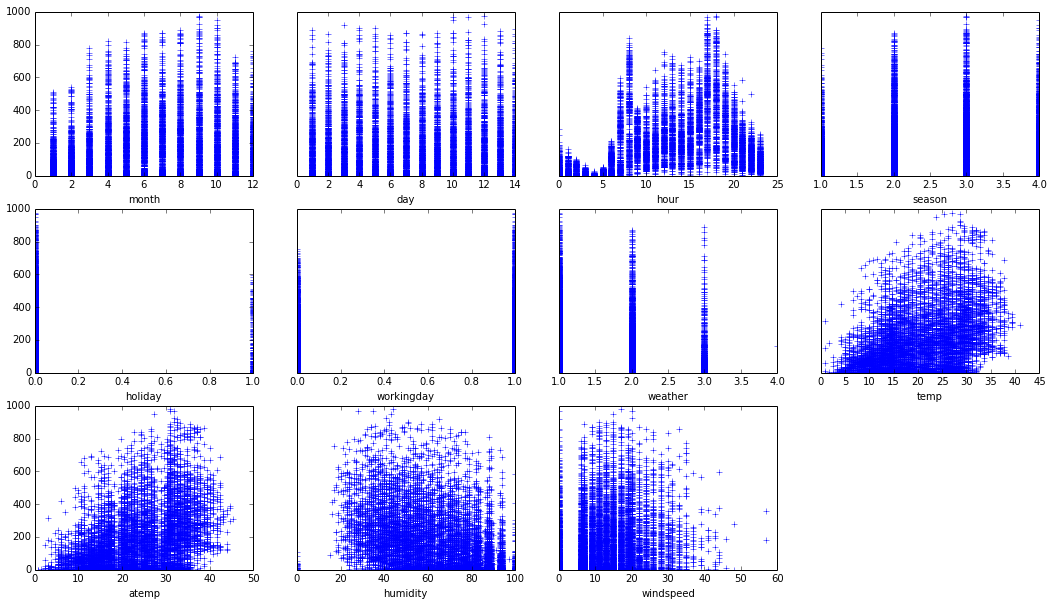

In [6]:
plt.figure(figsize=(18,10))

for i in range(11):
   plt.subplot(3,4,i+1)
   plt.plot(train_data[:,i],train_target,'+b')
   plt.xlabel('%s' %train_data1.columns.values[i])
   if (i)%4 > 0 :
        plt.yticks([])

plt.subplots_adjust(wspace=0.2)

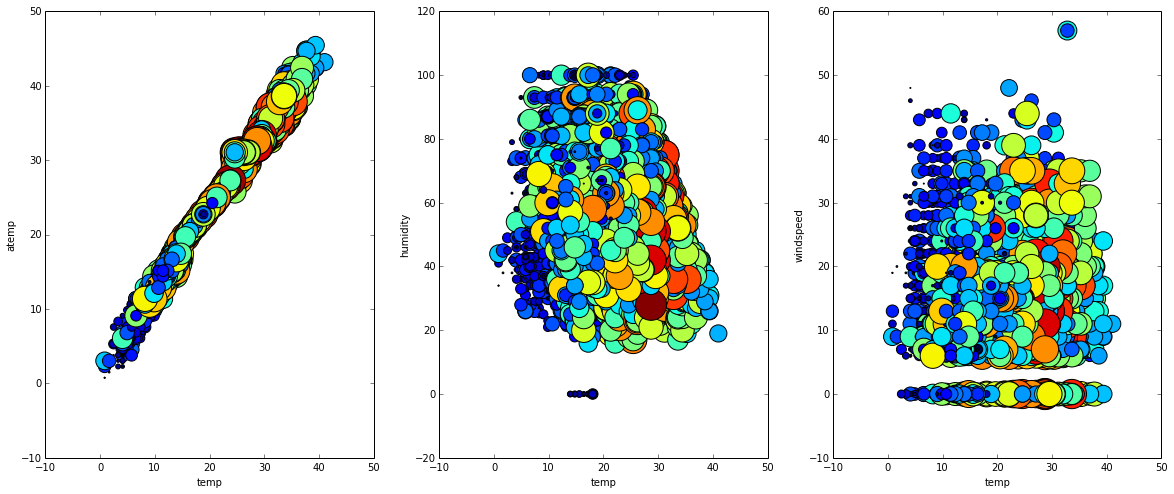

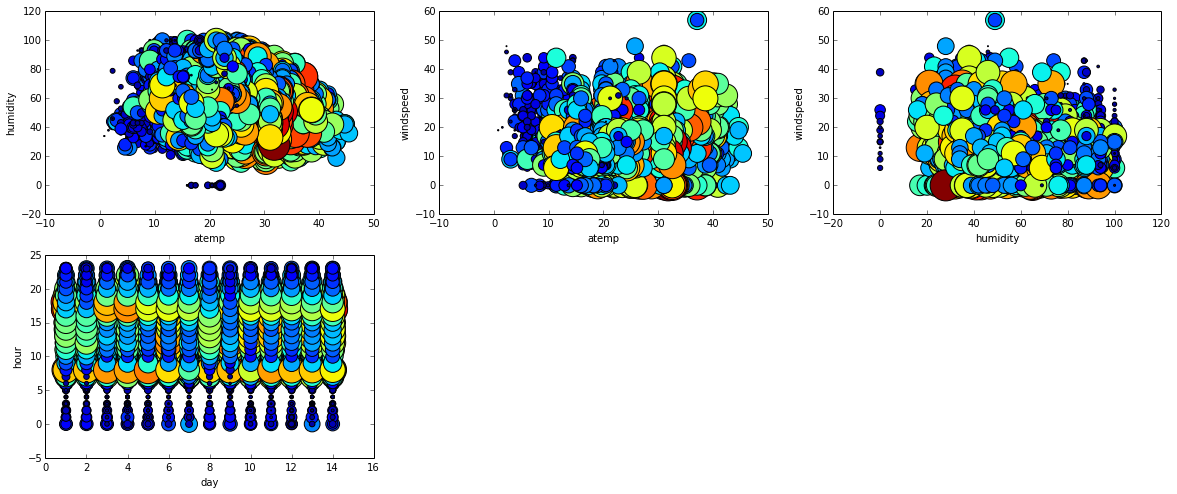

In [7]:
plt.figure(figsize=(20,8))

for i in range(8,11):
    plt.subplot(1,3,i-7)
    plt.scatter(train_data[:,7],train_data[:,i],c=train_target,s=train_target)
    plt.xlabel('%s' %train_data1.columns.values[7])
    plt.ylabel('%s' %train_data1.columns.values[i])
plt.subplots_adjust(wspace=0.2)

plt.figure(figsize=(20,8))

for i in range(9,11):
    plt.subplot(2,3,i-8)
    plt.scatter(train_data[:,8],train_data[:,i],c=train_target,s=train_target)
    plt.xlabel('%s' %train_data1.columns.values[8])
    plt.ylabel('%s' %train_data1.columns.values[i])
plt.subplot(2,3,3)
plt.scatter(train_data[:,9],train_data[:,10],c=train_target,s=train_target)
plt.xlabel('%s' %train_data1.columns.values[9])
plt.ylabel('%s' %train_data1.columns.values[10])
plt.subplots_adjust(wspace=0.2)
plt.subplot(2,3,4)
plt.scatter(train_data[:,1],train_data[:,2],c=train_target,s=train_target)
plt.xlabel('%s' %train_data1.columns.values[1])
plt.ylabel('%s' %train_data1.columns.values[2])
plt.subplots_adjust(wspace=0.2)


# Decision tree Resgression

### First Decicion tree with default parameters

In [8]:
from sklearn.tree import DecisionTreeRegressor
dtr1 = DecisionTreeRegressor()
dtr1.fit(train_data,train_target)
print "the score of dtree1 is",dtr1.score(valid_data,valid_target)

the score of dtree1 is 0.61309152992


### Cros validation by using LabelKFold 

In [9]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import LabelKFold

lkf = LabelKFold(train['day'], n_folds=3)
cv_score = cross_val_score(dtr1, train, target,cv=lkf)

print "the mean score is ",cv_score.mean(),"and the standard deviation is",cv_score.std()

the mean score is  0.687763772036 and the standard deviation is 0.0113045831058


### Selection of optimal parameters with GridSearchCV

In [10]:
from sklearn.grid_search import GridSearchCV

depth = range(1,20,2)
samp_s = range(2,10)
rand_sta = [0,1]
p_grid1=dict({'max_depth':depth,'min_samples_split':samp_s,'random_state':rand_sta})
           
lkf1 = LabelKFold(train_data1['day'], n_folds=3)

grd1 = GridSearchCV(dtr1,cv=lkf1,param_grid=p_grid1)
grd1.fit(train_data,train_target)

GridSearchCV(cv=sklearn.cross_validation.LabelKFold(n_labels=8026, n_folds=3),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'random_state': [0, 1], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [11]:
print grd1.best_score_
print grd1.best_params_
print grd1.best_estimator_

0.769688580865
{'min_samples_split': 9, 'random_state': 0, 'max_depth': 9}
DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=9,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')


In [12]:
new_dtr1 = grd1.best_estimator_
new_dtr1.fit(train_data,train_target)
y_pred1 = new_dtr1.predict(valid_data)
new_dtr1.score(valid_data,valid_target)

0.76184760643811067

### Second dtree regression by transforming the data

#### Find the importance coefficient of each feature

In [13]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import PCA
model = ExtraTreesRegressor()
model.fit(train,target)
import_feat = model.feature_importances_
print import_feat

[ 0.04833431  0.02859096  0.57934447  0.02419768  0.00397873  0.0659426
  0.02635821  0.07985025  0.06016576  0.05782014  0.02541689]


#### Transformation of data by multiply each feature by its importance coefficient

In [14]:
train_red=[]
valid_red =[]
test_red =[]

for i in range(0,11):
    train_red1 = import_feat[i]*train_data[:,i]
    valid_red1 = import_feat[i]*valid_data[:,i]
    test_red1 = import_feat[i]*test_data[:,i]
    train_red.append(train_red1)
    valid_red.append(valid_red1)
    test_red.append(test_red1)
valid_red = np.transpose(valid_red)
train_red = np.transpose(train_red)
test_red = np.transpose(test_red)

In [15]:
dtr2 = DecisionTreeRegressor()
dtr2.fit(train_red,train_target)
dtr2.score(valid_red,valid_target)

0.62205470570591781

In [16]:
lkf2 = LabelKFold(train_data1['day'], n_folds=3)
p_grid2=dict({'max_depth':depth,'min_samples_split':samp_s,'random_state':rand_sta})

grd2 = GridSearchCV(dtr2,cv=lkf2,param_grid=p_grid2)
grd2.fit(train_red,train_target)

GridSearchCV(cv=sklearn.cross_validation.LabelKFold(n_labels=8026, n_folds=3),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'random_state': [0, 1], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [18]:
print grd2.best_score_
print grd2.best_params_
print grd2.best_estimator_

0.769788216009
{'min_samples_split': 9, 'random_state': 0, 'max_depth': 9}
DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=9,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')


In [19]:
new_dtr2 = grd2.best_estimator_
new_dtr2.fit(train_red,train_target)
print "the validation score is",new_dtr2.score(valid_red,valid_target)

the validation score is 0.761847606438


#### Prediction of our test set

### AdaBoosRegressor  

In [20]:
from sklearn.ensemble import AdaBoostRegressor
abr1 = AdaBoostRegressor()
abr1.fit(train_red,train_target)
abr1.score(valid_red,valid_target)

0.58632714303330291

#### Cross vaidation

In [21]:
lkf = LabelKFold(train['day'], n_folds=3)
cv_score = cross_val_score(abr1, train, target,cv=lkf)

print "the mean score is ",cv_score.mean(),"and the standard deviation is",cv_score.std()

the mean score is  0.583883506806 and the standard deviation is 0.0318441168077


#### GridSearchCV

In [22]:
n_estim = [10,50,100,400]
#alp = np.logspace(-2, 2, 5)
p_grid = dict({'n_estimators':n_estim}) 
lkf1 = LabelKFold(train_data1['day'], n_folds=3)

#grd = GridSearchCV(<classifier>,cv=3,param_grid=<dictionary of parameters to investigate>)
#grd.fit(<training set>,<train set targets>)
grd2 = GridSearchCV(abr1,cv=lkf1,param_grid=p_grid)
grd2.fit(train_red,train_target)

GridSearchCV(cv=sklearn.cross_validation.LabelKFold(n_labels=8026, n_folds=3),
       error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 400]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [23]:
print grd2.best_score_
print grd2.best_params_
print grd2.best_estimator_

0.592385584194
{'n_estimators': 400}
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=400, random_state=None)


In [24]:
new_abr2 = grd2.best_estimator_
new_abr2.fit(train_red,train_target)
print "the validation score is",new_abr2.score(valid_red,valid_target)

the validation score is 0.582815957906


### Random Forest Regressor

In [25]:
from sklearn.ensemble.forest import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(train_red,train_target)
rfr.score(valid_red,valid_target)

0.7604852018150795

### Grid seach CV

In [26]:
n_estim = [10,50,100]
#alp = np.logspace(-2, 2, 5)
p_grid = dict({'n_estimators':n_estim,'max_depth':depth})#'min_samples_split':samp_s}) 
lkf1 = LabelKFold(train_data1['day'], n_folds=3)

#grd = GridSearchCV(<classifier>,cv=3,param_grid=<dictionary of parameters to investigate>)
#grd.fit(<training set>,<train set targets>)
grd2 = GridSearchCV(rfr,cv=lkf1,param_grid=p_grid)
grd2.fit(train_red,train_target)

GridSearchCV(cv=sklearn.cross_validation.LabelKFold(n_labels=8026, n_folds=3),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [27]:
print grd2.best_score_
print grd2.best_params_
print grd2.best_estimator_

0.824878570237
{'n_estimators': 100, 'max_depth': 17}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [28]:
new_rfr2 = grd2.best_estimator_
new_rfr2.fit(train_red,train_target)
print "the validation score is",new_rfr2.score(valid_red,valid_target)

the validation score is 0.787175088853


In [38]:
from sklearn.learning_curve import learning_curve
lfk = LabelKFold(train['day'], n_folds=3)
train_sizes, train_scores, test_scores = learning_curve(new_rfr2,train.values,target,train_sizes=np.linspace(.01, 1, 10),cv=lfk)

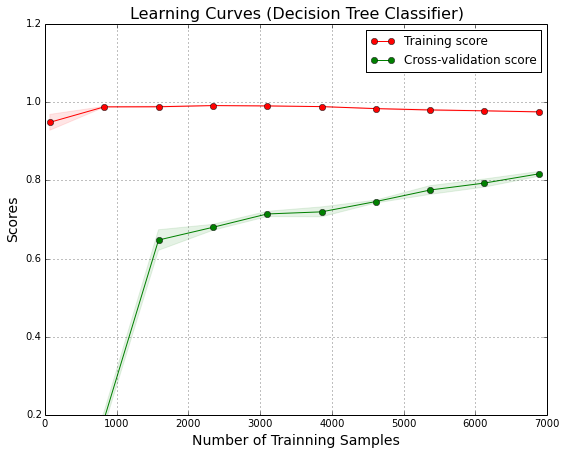

In [39]:
plt.figure(figsize=(9,7))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.ylim(0.2,1.2)
plt.xlabel("Number of Trainning Samples",fontsize=14)
plt.ylabel("Scores",fontsize=14)
plt.grid()
plt.title("Learning Curves (Decision Random Forest)",fontsize=16)

In [43]:
from sklearn.learning_curve import validation_curve

#Just an example
train_scores1,test_scores1 = validation_curve(new_rfr2,train.values,target,param_name='max_depth',param_range=np.arange(2,15),cv=lfk)
param_range=np.arange(2,15)

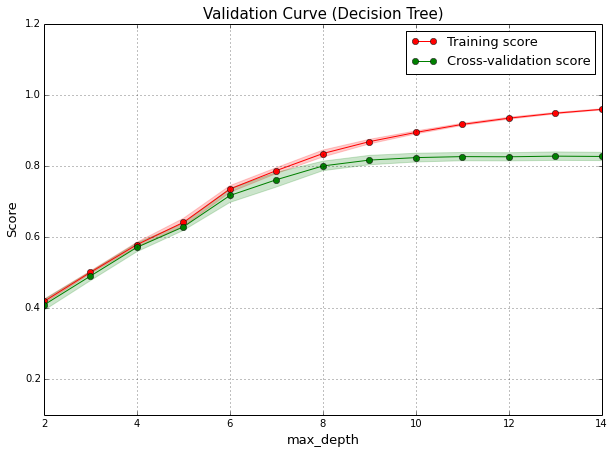

In [44]:
###Plot the validation curve
train_scores_mean1 = np.mean(train_scores1, axis=1)
train_scores_std1 = np.std(train_scores1, axis=1)
test_scores_mean1 = np.mean(test_scores1, axis=1)
test_scores_std1 = np.std(test_scores1, axis=1)
plt.figure(figsize=(10,7))

plt.plot(param_range, train_scores_mean1,'o-',label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean1 - train_scores_std1,
                 train_scores_mean1 + train_scores_std1, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean1, 'o-', label="Cross-validation score",color="g")
plt.fill_between(param_range, test_scores_mean1- test_scores_std1,
                 test_scores_mean1 + test_scores_std1, alpha=0.2, color="g")
plt.legend(loc="best",fontsize=13)
plt.title("Validation Curve (Decision Tree)",fontsize=15)
plt.xlabel("max_depth",fontsize=13)
plt.ylabel("Score",fontsize=13)
plt.ylim(0.1, 1.2)
plt.grid()

## Prediction of test set

In [52]:
test_predict_rfr = new_rfr2.predict(test_red)
test_predict_dtr = new_dtr2.predict(test_red)
test_predict_abr = new_abr2.predict(test_red)
test_predict_rfr = np.round(test_predict_rfr)

In [53]:
df_rfr = pd.DataFrame({'count':test_predict_rfr})

In [54]:
frames = [test,df_rfr]
result = pd.concat(frames,axis=1)

In [56]:
result.to_csv('bike_prediction_Serge_Leondres_Josiane.csv')

In [57]:
result

,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,1,20,0,1,0,1,1,10.66,11.365,56,26.0027,37
1,1,20,1,1,0,1,1,10.66,13.635,56,0.0000,32
2,1,20,2,1,0,1,1,10.66,13.635,56,0.0000,32
3,1,20,3,1,0,1,1,10.66,12.880,56,11.0014,30
4,1,20,4,1,0,1,1,10.66,12.880,56,11.0014,30
5,1,20,5,1,0,1,1,9.84,11.365,60,15.0013,12
6,1,20,6,1,0,1,1,9.02,10.605,60,15.0013,12
7,1,20,7,1,0,1,1,9.02,10.605,55,15.0013,3
8,1,20,8,1,0,1,1,9.02,10.605,55,19.0012,3
9,1,20,9,1,0,1,2,9.84,11.365,52,15.0013,3
